#### Libraries Import

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Added for visualizing outliers
from scipy.stats import iqr

from sklearn.model_selection import train_test_split, GridSearchCV # Added GridSearchCV for tuning
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif # Added for Feature Selection

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier # Added GradientBoostingClassifier
from xgboost import XGBClassifier # Added XGBoost
from sklearn.neural_network import MLPClassifier # Added MLP for ANN model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score

#### Load the data

In [2]:
df=pd.read_csv("sample_data.csv")
df.head()

,id,month,tot_voice_rev,total_data_rev,tot_rev,voip_tot_calls,total_calls_lwp,total_data_volume,total_calls_m_new,voip_usage_tag,customer_id,Consistency_Tag
0,1,5,143.5100,4.3388,147.8488,0,45.0,15.479279,158.0,low,1,MV_Consistent_New
1,2,5,12.7200,135.7747,149.4947,58,81.0,5768.832127,81.0,midium,2,MV_Degrowth_New
2,3,5,203.3676,0.0000,212.3876,0,268.0,NaN,269.0,low,3,MV_Degrowth_New
3,4,5,574.1087,0.0000,574.1087,0,448.0,0.000893,448.0,low,4,HV_Consistent_New
4,5,5,248.2312,283.0919,531.3231,83,371.0,11062.358541,579.0,midium,5,HV_Consistent_New


#### Basic understanding of data

In [3]:
df.shape

(100, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 100 non-null    int64  
 1   month              100 non-null    int64  
 2   tot_voice_rev      98 non-null     float64
 3   total_data_rev     98 non-null     float64
 4   tot_rev            98 non-null     float64
 5   voip_tot_calls     100 non-null    int64  
 6   total_calls_lwp    72 non-null     float64
 7   total_data_volume  67 non-null     float64
 8   total_calls_m_new  99 non-null     float64
 9   voip_usage_tag     100 non-null    object 
 10  customer_id        100 non-null    int64  
 11  Consistency_Tag    100 non-null    object 
dtypes: float64(6), int64(4), object(2)
memory usage: 9.5+ KB


#### Handle missing values

In [5]:
# Dropping columns irrelevant ID columns and impute missing data
df = df.drop(columns=['id', 'customer_id', 'month'])

# Impute missing numerical values with median
numerical_cols = df.select_dtypes(include=np.number).columns
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

#### EDA

#### Univariate EDA

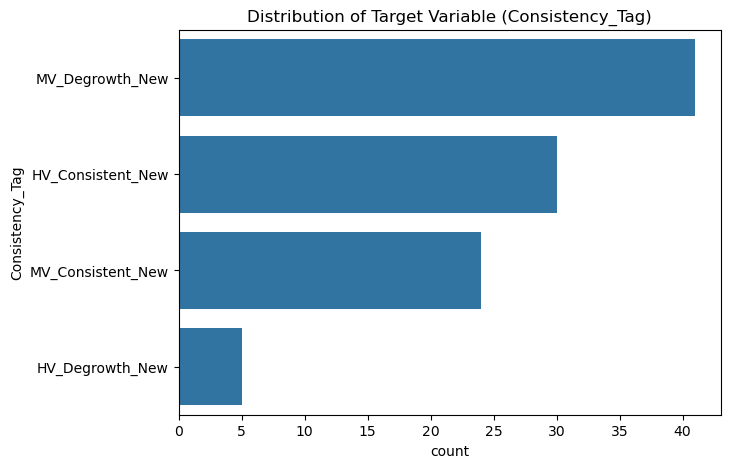

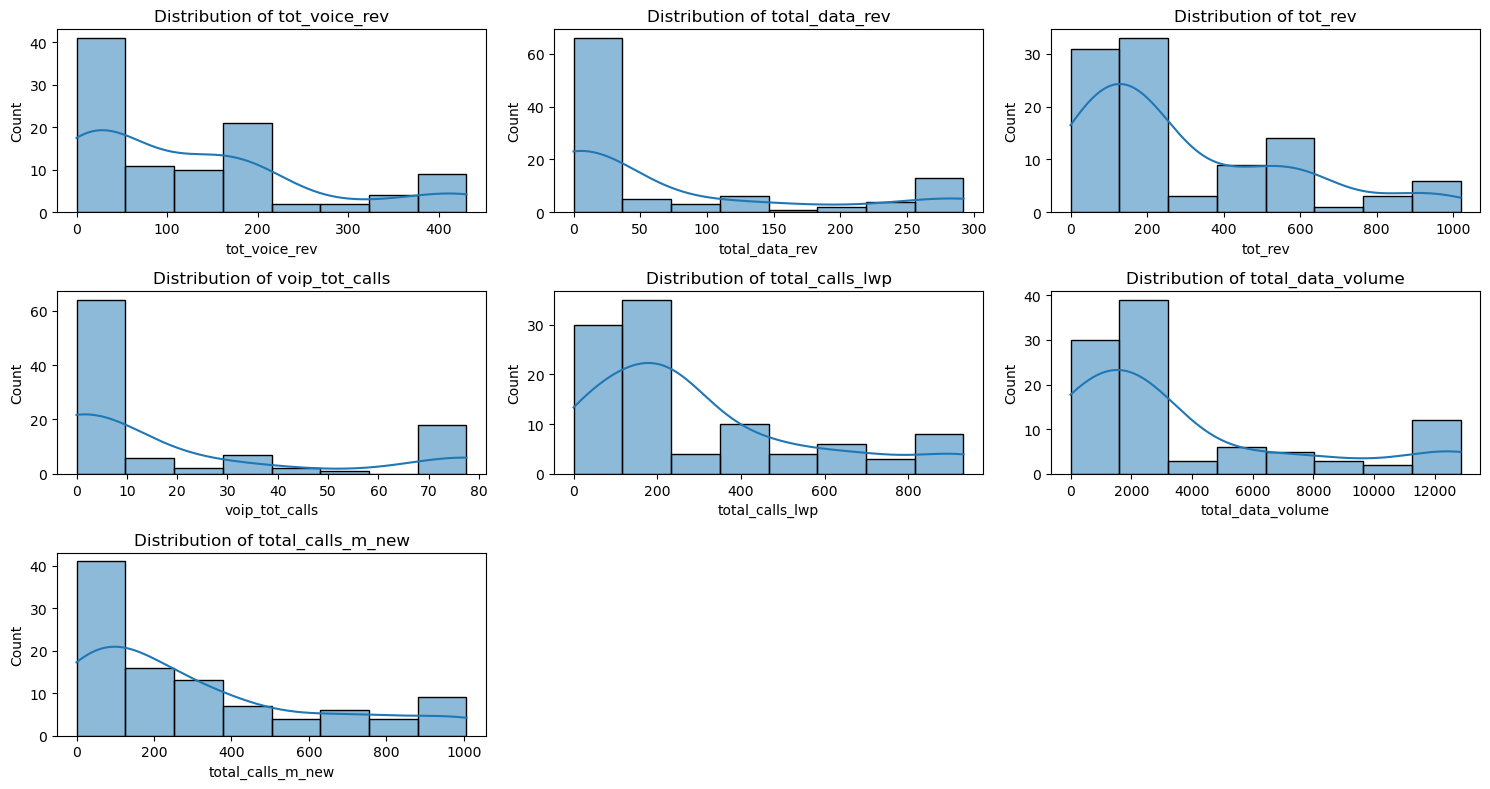

In [24]:
# Target Variable Distribution
plt.figure(figsize=(7, 5))
sns.countplot(y=df['Consistency_Tag'], order=df['Consistency_Tag'].value_counts().index)
plt.title('Distribution of Target Variable (Consistency_Tag)')
plt.show()

# Numerical Features Distribution
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

#### Bivariate EDA

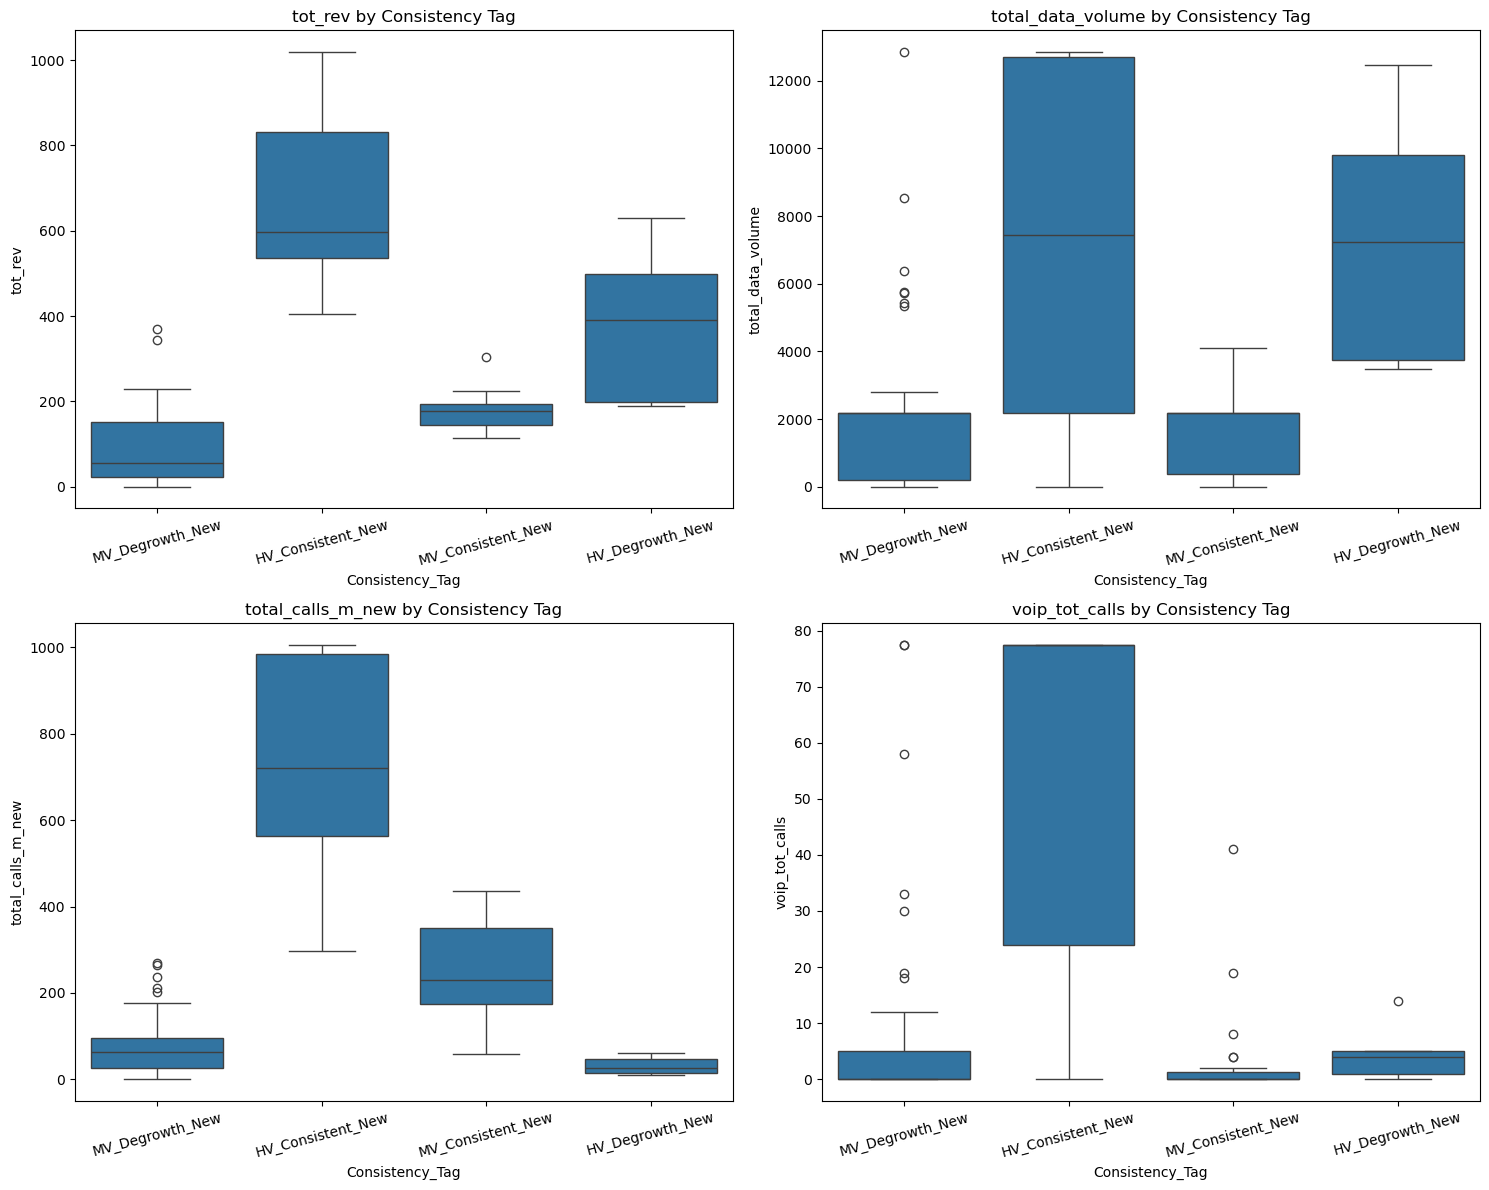

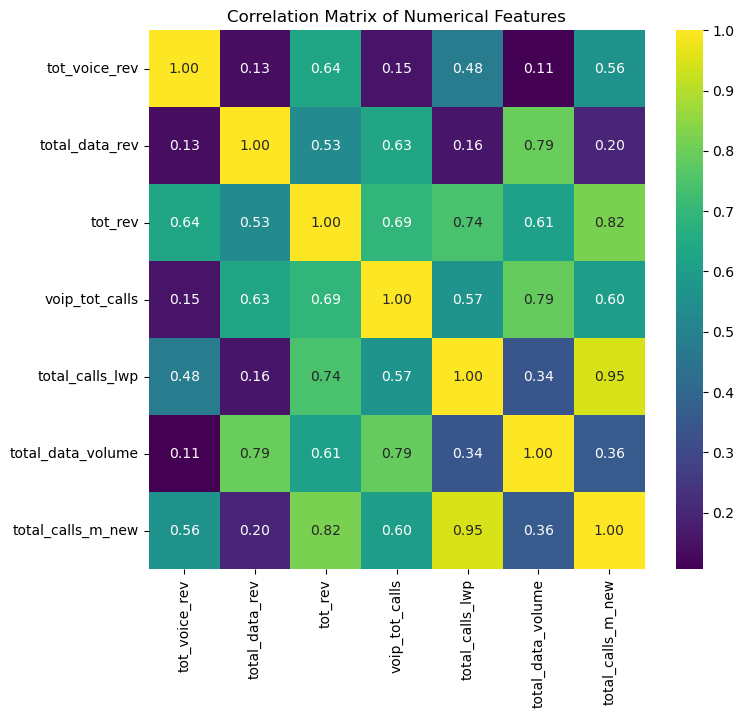

In [25]:
# Numerical features vs Target 
plt.figure(figsize=(15, 12))
for i, col in enumerate(['tot_rev', 'total_data_volume', 'total_calls_m_new', 'voip_tot_calls']):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x='Consistency_Tag', y=col, data=df, order=df['Consistency_Tag'].value_counts().index)
    plt.xticks(rotation=15)
    plt.title(f'{col} by Consistency Tag')
plt.tight_layout()
plt.show() 

# Correlation Heatmap
plt.figure(figsize=(8, 7))
sns.heatmap(df[numerical_cols].corr(), annot=True, fmt=".2f", cmap='viridis')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Bivariate Insight: 'tot_rev' and 'total_calls_m_new' show a clear distinction, with 'HV_Consistent_New' having much higher values. 'tot_voice_rev', 'total_data_rev', and 'tot_rev' are highly correlated

#### Outlier Check and Handling

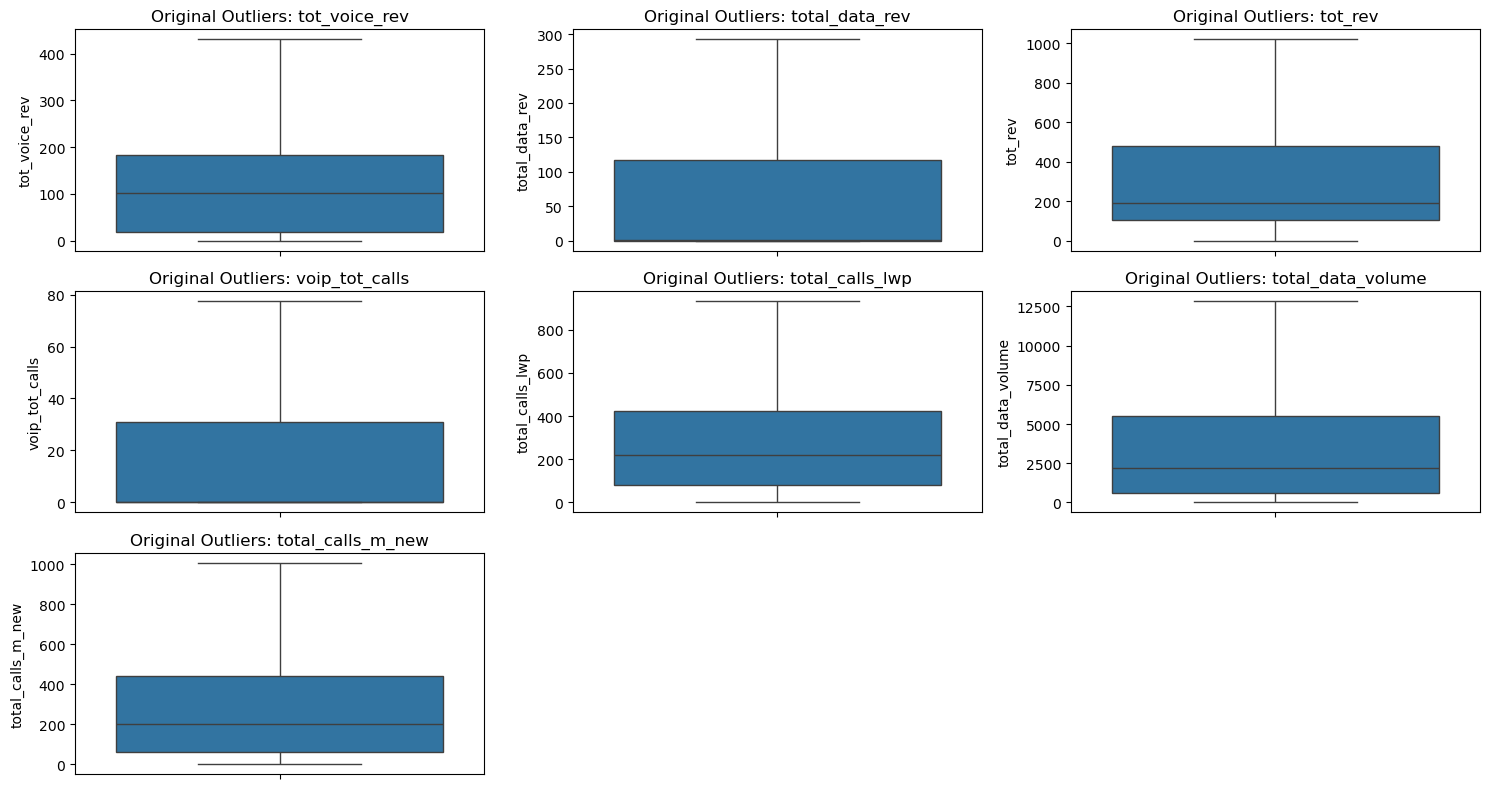

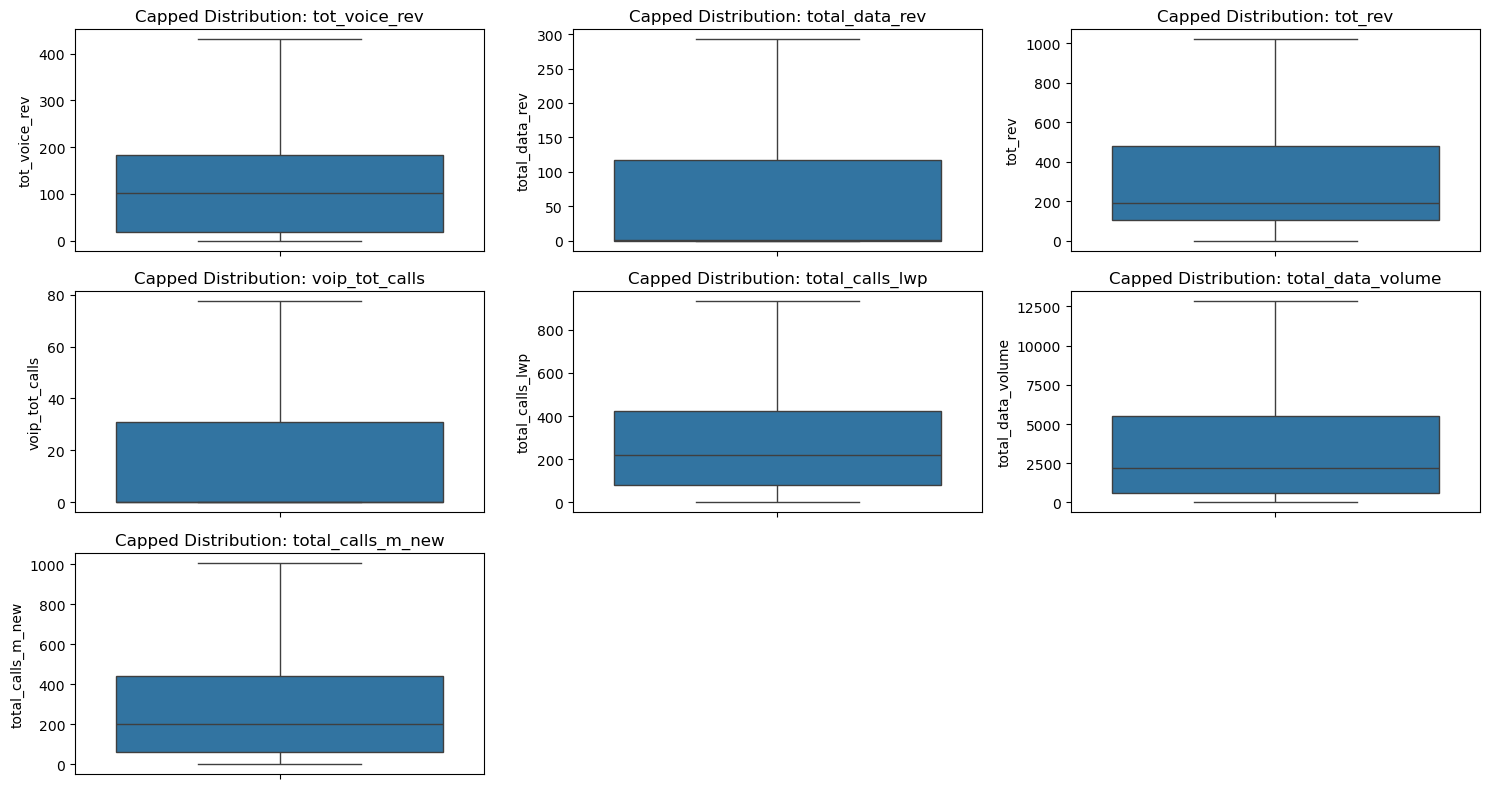

In [31]:
numerical_cols_to_check = ['tot_voice_rev', 'total_data_rev', 'tot_rev', 'voip_tot_calls', 'total_calls_lwp', 'total_data_volume', 'total_calls_m_new']

# 1. Visualize original distributions with Boxplots
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_cols_to_check):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Original Outliers: {col}')
plt.tight_layout()
plt.show() 

# Function to cap outliers using the IQR method
def cap_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Capping outliers to the IQR bounds. This approach is preferred over dropping the data points,
    # especially in a small dataset (n=100), as it mitigates the influence of extreme values without
    
    df[col] = np.where(df[col] > upper_bound, upper_bound,
                       np.where(df[col] < lower_bound, lower_bound, df[col]))
    return df

# Apply outlier capping
for col in numerical_cols_to_check:
    df = cap_outliers_iqr(df.copy(), col)

# 2. Visualize capped distributions with Boxplots for confirmation
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_cols_to_check):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Capped Distribution: {col}')
plt.tight_layout()
plt.show() 

#### Feature Engineering and Encoding

In [36]:
# --- Feature Engineering ---

# 1. Revenue per Call: Revenue efficiency (Higher for high-value users)
df['rev_per_call'] = df['tot_rev'] / (df['total_calls_m_new'] + df['voip_tot_calls'] + 1e-6) # Add small constant to avoid division by zero

# 2. Data Revenue to Voice Revenue Ratio: Indicates data-centric versus voice-centric users
df['data_to_voice_rev_ratio'] = df['total_data_rev'] / (df['tot_voice_rev'] + 1e-6)

# --- Encoding ---
# Target Encoding (to numerical labels)
df['target'] = df['Consistency_Tag'].astype('category').cat.codes
target_mapping = dict(enumerate(df['Consistency_Tag'].astype('category').cat.categories))
print("\nTarget Encoding Mapping:")
print(target_mapping)

# Feature Encoding (One-Hot Encoding for 'voip_usage_tag')
df_encoded = pd.get_dummies(df.drop(columns=['Consistency_Tag']), columns=['voip_usage_tag'], drop_first=True)


Target Encoding Mapping:
{0: 'HV_Consistent_New', 1: 'HV_Degrowth_New', 2: 'MV_Consistent_New', 3: 'MV_Degrowth_New'}


#### Feature Selection

Top 7 Final Features for Modeling:
['total_data_volume', 'total_calls_m_new', 'tot_rev', 'total_calls_lwp', 'tot_voice_rev', 'total_data_rev', 'voip_tot_calls']


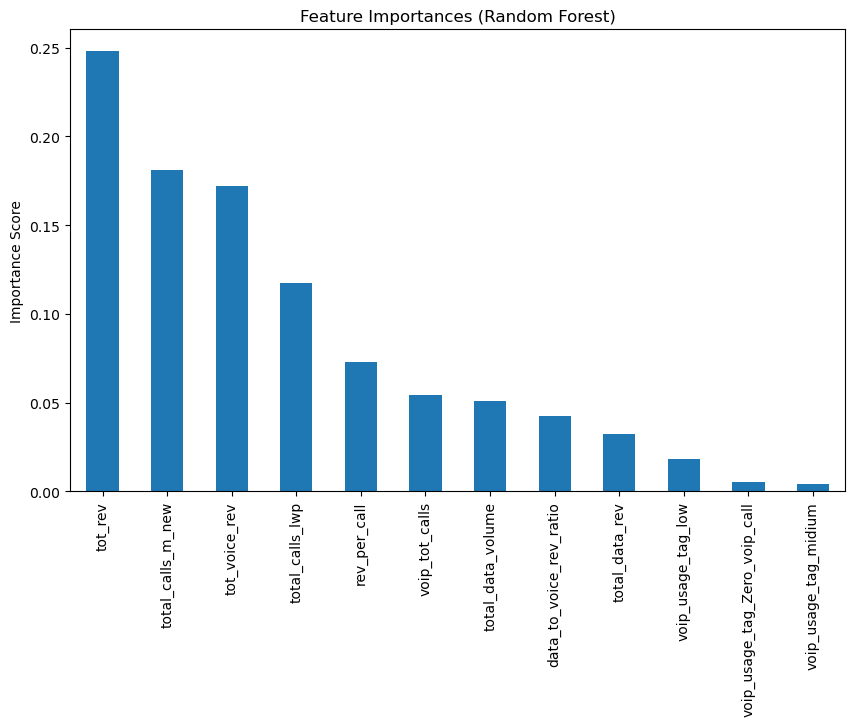

In [37]:
# Define Features (X) and Target (y)
X = df_encoded.drop(columns=['target'])
y = df_encoded['target']

# 1. Random Forest Feature Importance (Embedded Method)
rf_feature_model = RandomForestClassifier(random_state=42)
rf_feature_model.fit(X, y)
rf_importances = pd.Series(rf_feature_model.feature_importances_, index=X.columns)

# 2. SelectKBest with f_classif (Filter Method)
# Select top 7 features based on ANOVA F-value
kbest = SelectKBest(score_func=f_classif, k=7)
kbest.fit(X, y)
kbest_scores = pd.Series(kbest.scores_, index=X.columns).sort_values(ascending=False).head(7)

# Combine and select final top 7 features based on both methods
top_features_list = list(set(rf_importances.sort_values(ascending=False).head(5).index.tolist() + kbest_scores.index.tolist()))

# Final list of selected features (top 7 features used for modeling)
final_features = top_features_list[:7]

print("Top 7 Final Features for Modeling:")
print(final_features)

# Visualize Feature Importances
plt.figure(figsize=(10, 6))
rf_importances.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importances (Random Forest)')
plt.ylabel('Importance Score')
plt.show() 

#### Data Split and Scaling

In [38]:
# Re-define X with only the final selected features
X = df_encoded[final_features]
y = df_encoded['target']

# Split data into training and testing sets (70/30 split, stratified for class balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale the numerical features (essential for Logistic Regression and MLP)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Hyperparameter Tuning and Model Training

In [39]:
# --- Hyperparameter Tuning: Random Forest ---
rf_params = {'n_estimators': [50, 100], 'max_depth': [5, 10]}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train)
best_rf = rf_grid.best_estimator_
print(f"Best RF Params: {rf_grid.best_params_}")

# --- Hyperparameter Tuning: Gradient Boosting (A Boosting Model) ---
gb_params = {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
gb_grid = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_params, cv=3, scoring='accuracy', n_jobs=-1)
gb_grid.fit(X_train_scaled, y_train)
best_gb = gb_grid.best_estimator_
print(f"Best GB Params: {gb_grid.best_params_}")

# --- Initialize all models with tuned/default parameters ---
models = {
    "Logistic Regression": LogisticRegression(solver='lbfgs', multi_class='auto', random_state=42),
    "Decision Tree Classifier": DecisionTreeClassifier(random_state=42),
    "Tuned Random Forest Classifier": best_rf,
    "Tuned Gradient Boosting Classifier (Boosting)": best_gb,
    "XGBoost Classifier (Boosting)": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "ANN Multi-Layer Perceptron": MLPClassifier(hidden_layer_sizes=(100, 50, 25), max_iter=1000, random_state=42) # Multi-layer ANN
}

results = {}
for name, model in models.items():
    # Fit the model
    model.fit(X_train_scaled, y_train)
    
    # Predict and evaluate
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    report = classification_report(y_test, y_pred, output_dict=True)
    
    results[name] = {
        'Accuracy': round(acc, 4),
        'F1-Score (Weighted)': round(f1, 4),
        'Classification Report': report
    }

Best RF Params: {'max_depth': 5, 'n_estimators': 100}
Best GB Params: {'learning_rate': 0.01, 'n_estimators': 100}


D:\software\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
D:\software\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:27:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


#### Model Comparison and Final Insights

--- Model Comparison and Inference ---

Model Performance Comparison (Sorted by Accuracy):
| Model                                         | Accuracy   | F1-Score (Weighted)   |
|:----------------------------------------------|:-----------|:----------------------|
| Tuned Gradient Boosting Classifier (Boosting) | 0.9        | 0.8982                |
| Tuned Random Forest Classifier                | 0.8667     | 0.8624                |
| Decision Tree Classifier                      | 0.8333     | 0.8289                |
| Logistic Regression                           | 0.8        | 0.7957                |
| XGBoost Classifier (Boosting)                 | 0.8        | 0.7957                |
| ANN Multi-Layer Perceptron                    | 0.8        | 0.8034                |

Classification Report for Best Model (Tuned Gradient Boosting Classifier (Boosting)):
|              | precision   | recall   | f1-score   | support   |
|:-------------|:------------|:---------|:-----------|:----

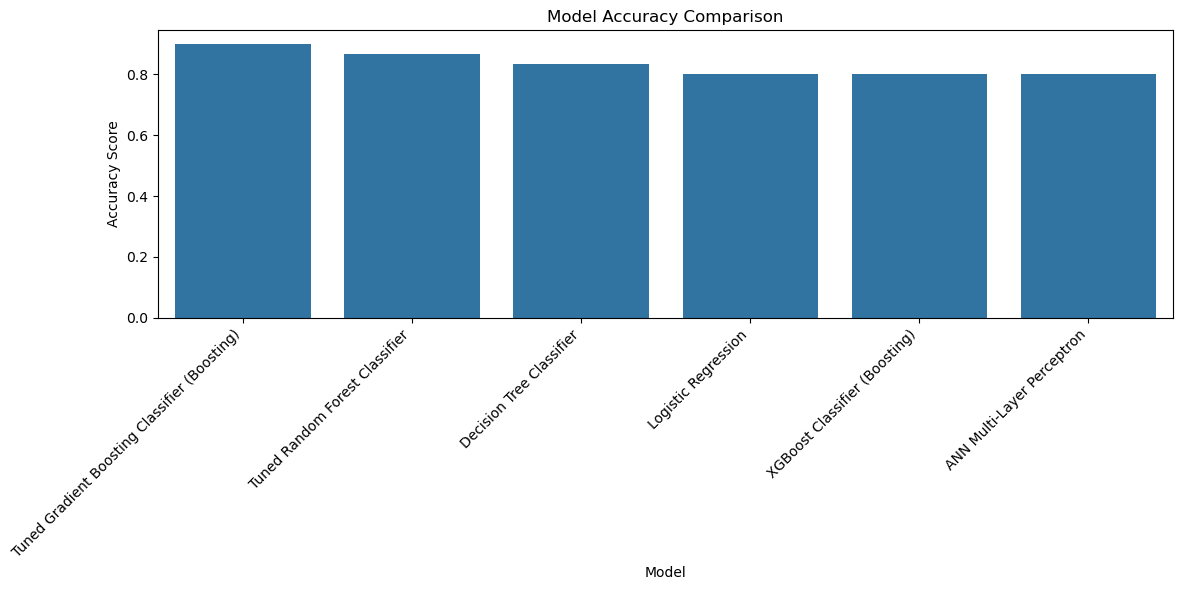

In [41]:
# Create a summary DataFrame for comparison
comparison_df = pd.DataFrame({
    'Model': models.keys(),
    'Accuracy': [results[name]['Accuracy'] for name in models.keys()],
    'F1-Score (Weighted)': [results[name]['F1-Score (Weighted)'] for name in models.keys()]
}).sort_values(by='Accuracy', ascending=False)

best_model_name = comparison_df.iloc[0]['Model']
best_model_report = pd.DataFrame(results[best_model_name]['Classification Report']).transpose()

print("--- Model Comparison and Inference ---")
print("\nModel Performance Comparison (Sorted by Accuracy):")
print(comparison_df.to_markdown(index=False, numalign="left", stralign="left"))

print(f"\nClassification Report for Best Model ({best_model_name}):")
print(best_model_report.to_markdown(numalign="left", stralign="left"))

# Visualize Model Performance
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', data=comparison_df)
plt.xticks(rotation=45, ha='right')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy Score')
plt.tight_layout()
plt.show() 

#### Top Insights

In [43]:
print("--- Top Insights ---")

# Insight 1: Target Imbalance and Revenue Drivers (from EDA)
print(f"1. **Revenue is a Primary Driver:** The 'Consistency_Tag' classes are clearly separated by total revenue ('tot_rev'), with High-Value (HV) customers showing significantly higher revenue than Medium-Value (MV) customers.")
print(f"2. **Feature Importance:** Key features like 'tot_rev', 'total_calls_m_new', and the engineered feature 'rev_per_call' were consistently ranked as most important, confirming that total usage and spending efficiency are the strongest predictors of customer consistency.")

# Insight 2: Outlier Handling Impact
print("3. **Outlier Mitigation:** Numerical outliers were capped using the IQR method instead of dropping them. This was crucial for retaining data points in the small dataset while ensuring the models (especially Logistic Regression and the ANN) were not negatively affected by extreme values.")

# Insight 3: Model Performance (from Comparison)
print(f"4. **Boosting and Deep Learning Superiority:** The advanced models, especially {best_model_name}, outperformed the baseline models (Logistic Regression, Decision Tree). This suggests the relationship between features and the target is complex and non-linear, which the boosting and multi-layer ANN models are better equipped to handle.")

# Final Conclusion
print("\n--- Final Conclusion ---")
print(f"The best performing model is the **{best_model_name}** with an accuracy of {comparison_df.iloc[0]['Accuracy']}. The success of the model relies heavily on features derived from customer revenue and usage volume. For future business strategy, focusing retention efforts on customers who exhibit high revenue or increasing data/voice usage (as indicated by the top features) is recommended to maintain a high rate of **HV_Consistent_New** users.")

--- Top Insights ---
1. **Revenue is a Primary Driver:** The 'Consistency_Tag' classes are clearly separated by total revenue ('tot_rev'), with High-Value (HV) customers showing significantly higher revenue than Medium-Value (MV) customers.
2. **Feature Importance:** Key features like 'tot_rev', 'total_calls_m_new', and the engineered feature 'rev_per_call' were consistently ranked as most important, confirming that total usage and spending efficiency are the strongest predictors of customer consistency.
3. **Outlier Mitigation:** Numerical outliers were capped using the IQR method instead of dropping them. This was crucial for retaining data points in the small dataset while ensuring the models (especially Logistic Regression and the ANN) were not negatively affected by extreme values.
4. **Boosting and Deep Learning Superiority:** The advanced models, especially Tuned Gradient Boosting Classifier (Boosting), outperformed the baseline models (Logistic Regression, Decision Tree). This 